## Algoritmo Genético

No jupyter anterior utilizamos o algoritmo Gradiente Decrescente para otimizar a função objetivo, afim de comparações, dessa vez utilizaremos um algoritmo genético.

In [1]:
from random import randint, uniform, random
from tqdm import tqdm
import numpy as np

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

In [3]:
# Parâmetros iniciais

tamanhoPopulacao = 30
taxaMutacao = 0.01
taxaCrossover = 0.85
numeroGeracoes = 70
quantidadeVariaveis = 3 # Para o sistema dinâmico avaliado, apenas os controles devem ser avaliados
quantidadeTrocas = 2 # Posicoes a serem trocadas na 

In [4]:
def gerarPopulacao(xMin, xMax):
    populacao = np.zeros((tamanhoPopulacao,quantidadeVariaveis))
    for individuo in range(tamanhoPopulacao):
        for pos in range(quantidadeVariaveis):
            populacao[individuo,pos] = uniform(xMin, xMax)
    return populacao

In [5]:
def divisaoFitness(valorFuncaoObjetivo):
    divisao = 0
    for i in range(len(valorFuncaoObjetivo)):
        divisao += valorFuncaoObjetivo[i]
    return divisao

def fitness(valorFuncaoObjetivo):
    return valorFuncaoObjetivo/divisaoFitness(valorFuncaoObjetivo)

In [6]:
def calcularFuncao(populacao, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise):
    valorFuncaoObj = np.zeros(tamanhoPopulacao)
    for individuo in range(tamanhoPopulacao):
        valorFuncaoObj[individuo] = funcaoObjetivo(populacao[individuo,:], iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    return valorFuncaoObj

In [7]:
def selecao(valorFitness):
    pos = np.random.choice(range(tamanhoPopulacao), 2, replace=False)
    valor = valorFitness[pos[0]] < valorFitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [8]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [9]:
def mutacao(individuo):
    pos = np.random.choice(range(quantidadeVariaveis),  quantidadeTrocas ,replace=False)
    individuo[pos[0]] = individuo[pos[1]]
    individuo[pos[1]] = individuo[pos[0]]
    return individuo

In [10]:
import matplotlib.pyplot as plt

In [11]:
def main(xMin, xMax, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise):
    pop = gerarPopulacao(xMin, xMax)
    fo = calcularFuncao(pop, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    fit = fitness(fo)
    melhor_fo = np.zeros(numeroGeracoes)
    melhor_ind_geracao = np.zeros((numeroGeracoes, quantidadeVariaveis))
    for geracao in range(numeroGeracoes):
        new_pop = np.empty((0, quantidadeVariaveis))
        for i in range(round((tamanhoPopulacao) / 2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < taxaCrossover:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :]) 
                if random() < taxaMutacao:    
                    filho1 = mutacao(filho1)
                    filho2 = mutacao(filho2)  
                new_pop = np.vstack([new_pop, filho1, filho2])     
            else:
                pais = np.vstack([pop[pai1, :], pop[pai2, :]])
                new_pop = np.vstack([new_pop, pais])
        pop = new_pop    
        fo = calcularFuncao(pop, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)

    
    #plt.plot(melhor_fo)
    #plt.xlim(0, numeroGeracoes)
    #plt.ylabel('Gerações')
    #plt.ylabel('Melhor Custo')
    #plt.title('Evolução da função objetivo - GA')
    #plt.grid(True)
    #plt.show()
    

    return pop[pos_min_fo,:][0,0]

In [12]:
# Função de origem e destino
ondaOrigem = [[complex(1.0,0.0)],[complex(0.0,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

hamiltoniano = np.zeros((2,2), dtype=np.complex_) # Hamiltoniano
A = (1/2*np.pi)
B = (3/2*np.pi)
hamiltoniano = [[A, 0], [0, B]]

iteracao = 0
fatorRungeKutta = 0.01
tempoAnalise = 2000
horizonte = 3

xMin = -10
xMax = 10

constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1

minimo = main(xMin, xMax, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)

In [13]:
minimo

array([0.46594224, 2.90274597, 1.24808091])

In [14]:
while iteracao < 2000:
    
    print(f"Iteração: {iteracao}")
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, sum(minimo)],[sum(minimo),0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]

    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
    
    ## Adaptação da onda ao controle
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(minimo, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)

    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)

    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]

    xMax = 10
    xMin = -10
    
    A = (1/2*np.pi)
    B = (3/2*np.pi)
    hamiltoniano = [[A, 0], [0, B]]
    
    iteracao += 1

    minimo = main(xMax, xMin, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)

Iteração: 0
Iteração: 1
Iteração: 2
Iteração: 3
Iteração: 4
Iteração: 5
Iteração: 6
Iteração: 7
Iteração: 8
Iteração: 9
Iteração: 10
Iteração: 11
Iteração: 12
Iteração: 13
Iteração: 14
Iteração: 15
Iteração: 16
Iteração: 17
Iteração: 18
Iteração: 19
Iteração: 20
Iteração: 21
Iteração: 22
Iteração: 23
Iteração: 24
Iteração: 25
Iteração: 26
Iteração: 27
Iteração: 28
Iteração: 29
Iteração: 30
Iteração: 31
Iteração: 32
Iteração: 33
Iteração: 34
Iteração: 35
Iteração: 36
Iteração: 37
Iteração: 38
Iteração: 39
Iteração: 40
Iteração: 41
Iteração: 42
Iteração: 43
Iteração: 44
Iteração: 45
Iteração: 46
Iteração: 47
Iteração: 48
Iteração: 49
Iteração: 50
Iteração: 51
Iteração: 52
Iteração: 53
Iteração: 54
Iteração: 55
Iteração: 56
Iteração: 57
Iteração: 58
Iteração: 59
Iteração: 60
Iteração: 61
Iteração: 62
Iteração: 63
Iteração: 64
Iteração: 65
Iteração: 66
Iteração: 67
Iteração: 68
Iteração: 69
Iteração: 70
Iteração: 71
Iteração: 72
Iteração: 73
Iteração: 74
Iteração: 75
Iteração: 76
Iteração:

Iteração: 594
Iteração: 595
Iteração: 596
Iteração: 597
Iteração: 598
Iteração: 599
Iteração: 600
Iteração: 601
Iteração: 602
Iteração: 603
Iteração: 604
Iteração: 605
Iteração: 606
Iteração: 607
Iteração: 608
Iteração: 609
Iteração: 610
Iteração: 611
Iteração: 612
Iteração: 613
Iteração: 614
Iteração: 615
Iteração: 616
Iteração: 617
Iteração: 618
Iteração: 619
Iteração: 620
Iteração: 621
Iteração: 622
Iteração: 623
Iteração: 624
Iteração: 625
Iteração: 626
Iteração: 627
Iteração: 628
Iteração: 629
Iteração: 630
Iteração: 631
Iteração: 632
Iteração: 633
Iteração: 634
Iteração: 635
Iteração: 636
Iteração: 637
Iteração: 638
Iteração: 639
Iteração: 640
Iteração: 641
Iteração: 642
Iteração: 643
Iteração: 644
Iteração: 645
Iteração: 646
Iteração: 647
Iteração: 648
Iteração: 649
Iteração: 650
Iteração: 651
Iteração: 652
Iteração: 653
Iteração: 654
Iteração: 655
Iteração: 656
Iteração: 657
Iteração: 658
Iteração: 659
Iteração: 660
Iteração: 661
Iteração: 662
Iteração: 663
Iteração: 664
Iteraç

Iteração: 1168
Iteração: 1169
Iteração: 1170
Iteração: 1171
Iteração: 1172
Iteração: 1173
Iteração: 1174
Iteração: 1175
Iteração: 1176
Iteração: 1177
Iteração: 1178
Iteração: 1179
Iteração: 1180
Iteração: 1181
Iteração: 1182
Iteração: 1183
Iteração: 1184
Iteração: 1185
Iteração: 1186
Iteração: 1187
Iteração: 1188
Iteração: 1189
Iteração: 1190
Iteração: 1191
Iteração: 1192
Iteração: 1193
Iteração: 1194
Iteração: 1195
Iteração: 1196
Iteração: 1197
Iteração: 1198
Iteração: 1199
Iteração: 1200
Iteração: 1201
Iteração: 1202
Iteração: 1203
Iteração: 1204
Iteração: 1205
Iteração: 1206
Iteração: 1207
Iteração: 1208
Iteração: 1209
Iteração: 1210
Iteração: 1211
Iteração: 1212
Iteração: 1213
Iteração: 1214
Iteração: 1215
Iteração: 1216
Iteração: 1217
Iteração: 1218
Iteração: 1219
Iteração: 1220
Iteração: 1221
Iteração: 1222
Iteração: 1223
Iteração: 1224
Iteração: 1225
Iteração: 1226
Iteração: 1227
Iteração: 1228
Iteração: 1229
Iteração: 1230
Iteração: 1231
Iteração: 1232
Iteração: 1233
Iteração: 

Iteração: 1715
Iteração: 1716
Iteração: 1717
Iteração: 1718
Iteração: 1719
Iteração: 1720
Iteração: 1721
Iteração: 1722
Iteração: 1723
Iteração: 1724
Iteração: 1725
Iteração: 1726
Iteração: 1727
Iteração: 1728
Iteração: 1729
Iteração: 1730
Iteração: 1731
Iteração: 1732
Iteração: 1733
Iteração: 1734
Iteração: 1735
Iteração: 1736
Iteração: 1737
Iteração: 1738
Iteração: 1739
Iteração: 1740
Iteração: 1741
Iteração: 1742
Iteração: 1743
Iteração: 1744
Iteração: 1745
Iteração: 1746
Iteração: 1747
Iteração: 1748
Iteração: 1749
Iteração: 1750
Iteração: 1751
Iteração: 1752
Iteração: 1753
Iteração: 1754
Iteração: 1755
Iteração: 1756
Iteração: 1757
Iteração: 1758
Iteração: 1759
Iteração: 1760
Iteração: 1761
Iteração: 1762
Iteração: 1763
Iteração: 1764
Iteração: 1765
Iteração: 1766
Iteração: 1767
Iteração: 1768
Iteração: 1769
Iteração: 1770
Iteração: 1771
Iteração: 1772
Iteração: 1773
Iteração: 1774
Iteração: 1775
Iteração: 1776
Iteração: 1777
Iteração: 1778
Iteração: 1779
Iteração: 1780
Iteração: 

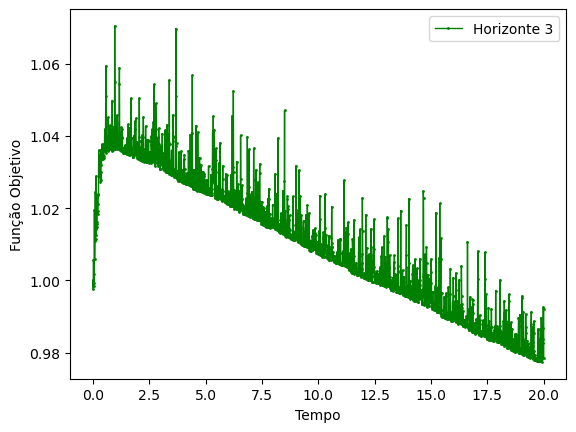

In [15]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0])/abs(valoresFuncaoObjetivo3[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.legend(loc="upper right")
plt.show()

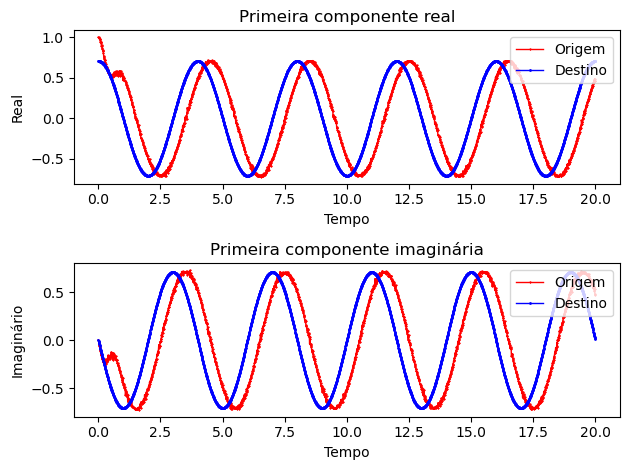

In [16]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()
